In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mainpath='../csse_covid_19_data/csse_covid_19_time_series/'

In [3]:
def getCountryStats(country='world',printinfo=True,plot=True,savefig=False):
    data=dict()
    cases=['confirmed','deaths']
    for case in cases:            
        df=pd.read_csv(mainpath+'time_series_covid19_{}_global.csv'.format(case))
        days=df.columns[4:]
        
        if country.lower()!='world':
            isCountry=df['Country/Region']==country
            df=df[isCountry]
        
        totalcases= np.array(df[days].sum())
        
        if case=='confirmed':
            start=totalcases>0
            # Days after first confirmed
            data['days']= days[start]
        data[case]=totalcases[start]  
        
    if printinfo:  
        print('COVID-19 FIRST DAY IN {}: {}'.format(country.upper(),data['days'][0])) 
        print('  TOTAL CASES IN {}'.format(country.upper()))
        print('=========================')
        for case in cases:
            print('{:9s}: {:6d}'.format(case.upper(),int(max(data[case]))))
        print('')
    
    if plot:
        plt.figure(figsize=(16,6))       
        for case in cases:
            plt.plot_date(data['days'],data[case],'-o',label=case)
        plt.title('{} COVID-19 CASES'.format(country.upper()))
        plt.ylabel('Cases')
        plt.xlabel('Days')
        plt.legend()
        plt.tight_layout()
        plt.grid(linestyle='--')
        if max(data['confirmed'])>15000:
            plt.yscale('log')
        if len(data['days'])>30:
            plt.xticks(data['days'][::2])
        plt.tick_params(axis='x',rotation=90)
        if savefig:
            plt.savefig('Plots/{}.png'.format(country.lower()),bbox_inches = "tight")
    return data

def plot_multicountry(countries,case='confirmed',savefig=False):
    plt.figure(figsize=(16,6))
    plt.title('{}'.format(case.upper()))
    plt.ylabel('Cases')
    plt.xlabel('Days after First Confirmed')
    for country in countries:
        countrystats=getCountryStats(country,printinfo=False,plot=False)
        days=np.arange(len(countrystats['days']))
        plt.plot(days,countrystats[case.lower()],'-o',label=country)
    plt.grid(linestyle='--')
    plt.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig('Plots/multiple_{}.png'.format(case.lower()))

# World

COVID-19 FIRST DAY IN WORLD: 1/22/20
  TOTAL CASES IN WORLD
CONFIRMED: 467593
DEATHS   :  21180



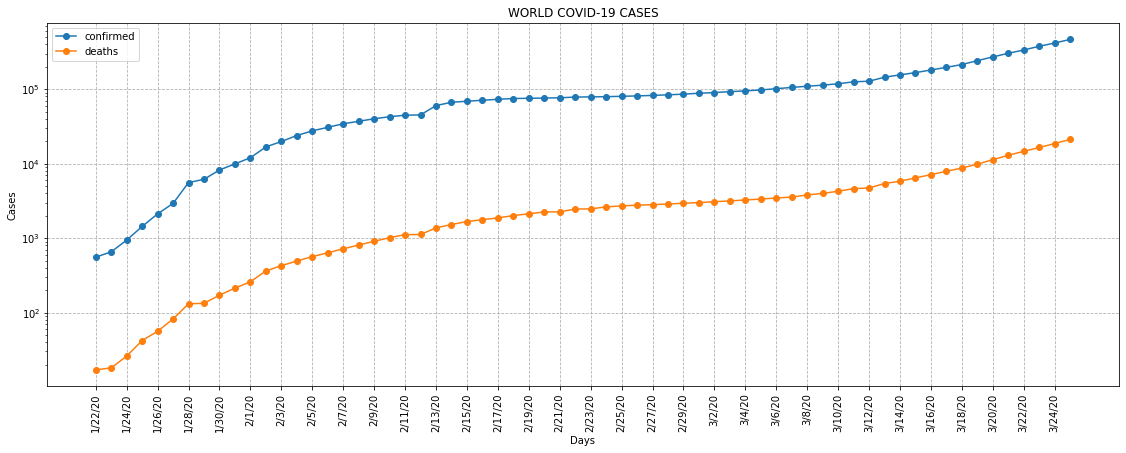

In [8]:
stats=getCountryStats(savefig=True)

# Mexico

COVID-19 FIRST DAY IN MEXICO: 2/28/20
  TOTAL CASES IN MEXICO
CONFIRMED:    405
DEATHS   :      5



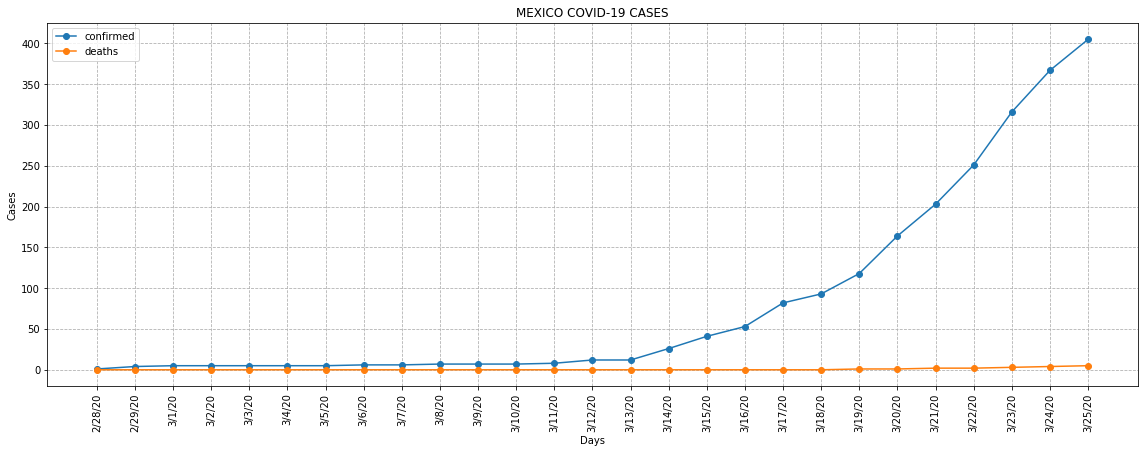

In [5]:
mxStats=getCountryStats('Mexico',savefig=True)

# Latin America

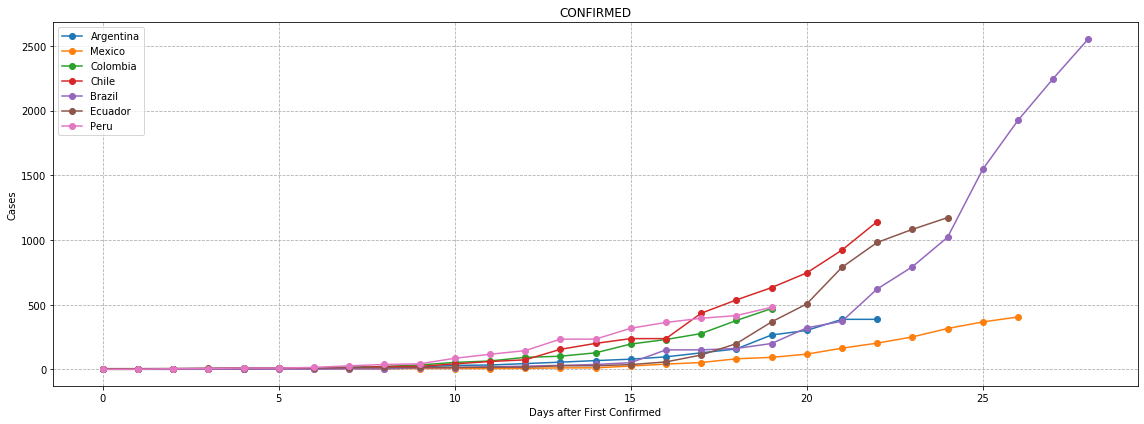

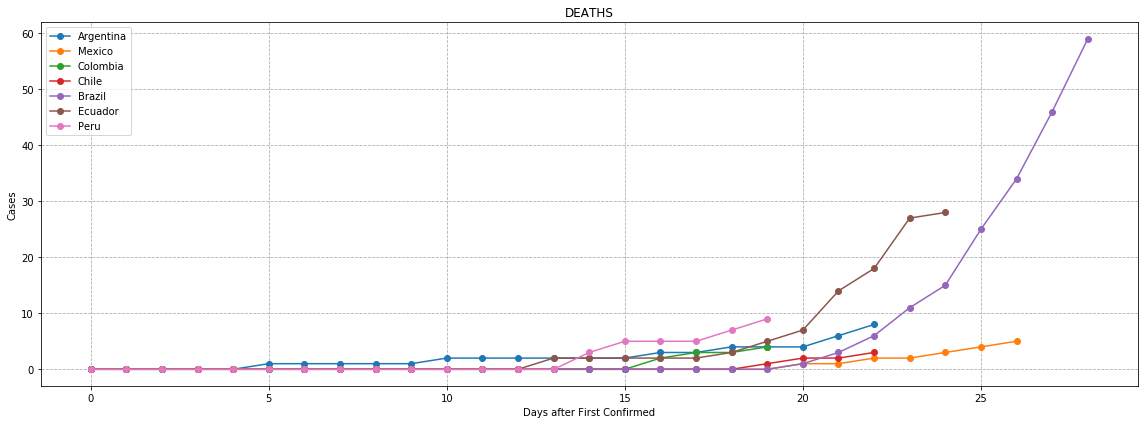

In [6]:
countries=['Argentina','Mexico','Colombia','Chile','Brazil','Ecuador','Peru']
plot_multicountry(countries,case='confirmed',savefig=True)
plot_multicountry(countries,case='deaths',savefig=True)